In [1]:
import copy
from config import CONFIG_mkB
from hospital_model import hospital_model

In [4]:
conf = copy.deepcopy(CONFIG_mkB) # prevent side effect on default configuration
conf['seed'] = 2025
conf['total'] = [10,10,10] # increase slack capacity for demo. changes to this conf param mid-simulation may cause issues
hospital = hospital_model(conf)
hospital.run_for(1000)
conf['means'][0] = 200 # increase patient arrival delay for demo purposes
hospital.run_for(1000)
conf['staffed'] = [0,1,1] # change what facilities are staffed
hospital.run_for(1000)

--- Starting state of this simulation run: ---
time: 0
slack requests: [7, 9, 7]
--- Starting state of this simulation run: ---
time: 1000
slack requests: [7, 9, 7]
--- Starting state of this simulation run: ---
time: 2000
slack requests: [10, 9, 9]


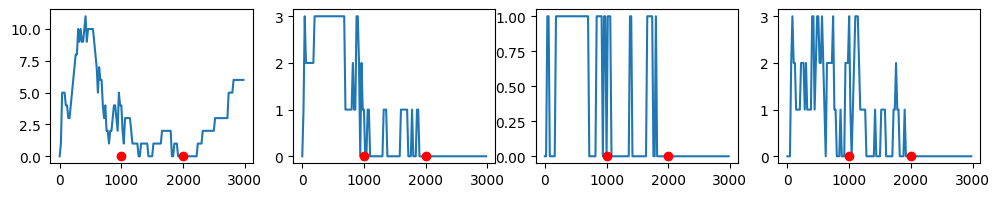

In [5]:
# visualize rooms:
import matplotlib.pyplot as plt

plot_stages = len(hospital.results['snapshots'][0]['patient_counts']) # plot each metric monitored by snapshots
fig, axs = plt.subplots(figsize=(3*plot_stages,2),ncols = plot_stages)
x = [s['time'] for s in hospital.results['snapshots']] # snapshot times on x-axis
for a in range(len(axs)):
    axs[a].plot(x,[s['patient_counts'][a] for s in hospital.results['snapshots']])
    axs[a].plot([1000,2000],[0,0],'ro') # example param changes

OR utilization: 1.0%
OR blocked for 0.0% of the time


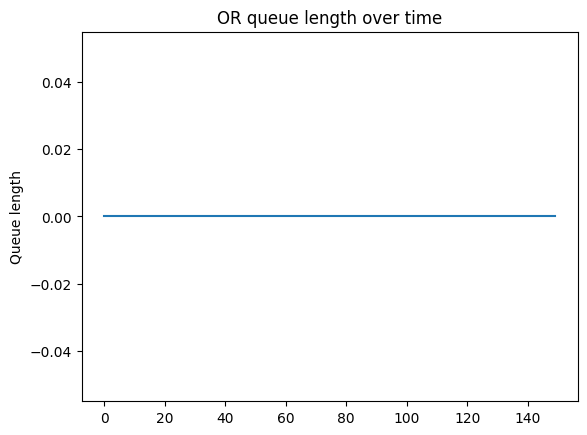

In [41]:
import numpy as np
queue_lengths = []#list of or queue lengths
blocked_time = hospital.results["or_time_blocked"]#total or blocked time
total_time = hospital.results["snapshots"][-1]["time"]#total simulation time
for snapshot in hospital.results["snapshots"]:
    queue_lengths.append(snapshot["or_queue"])

plt.plot(queue_lengths)

plt.title("OR queue length over time")
plt.ylabel("Queue length")

active_times = hospital.results["util_active"]
total_times  = hospital.results["total_active"]
print(f'OR utilization: {np.round(active_times[1]/total_times[1],3)}%')
print(f'OR blocked for {np.round(blocked_time/total_time,3)*100}% of the time')


In [84]:
from config import CONFIG_mkB
from hospital_model import hospital_model
import numpy as np
def simulate(samples,rooms):
    utilizations = []
    blocked = []
    for sample in range(samples):

        conf = CONFIG_mkB.copy() # prevent side effect on default configuration
        conf['seed'] = sample # all three hospital configurations use the same seed, but there is 20 different seeds total.
        conf['total'] = [10,10,10] # increase slack capacity for demo. changes to this conf param dont have effect mid-simulation
        hospital = hospital_model(conf)

        #hospital.run_for(1000)
        #conf['means'][0] = 200 # increase patient arrival delay for demo purposes
        # hospital.run_for(1000)

        conf['staffed'] = rooms # change what facilities are staffed
        #print(hospital.env.now)
        hospital.run_for(100)#warm up
        env_time = hospital.env.now #env time after warmup
        #print(env_time)
        #Resetting statsistics
        hospital.results["or_time_blocked"] = 0
        hospital.results["util_active"] = [0,0,0]
        hospital.results["total_active"] = [0,0,0]
        hospital.results["snapshots"]=[]

        hospital.run_for(1000)#actual simulation run
        active_times = hospital.results["util_active"]
        total_times  = hospital.results["total_active"]
        blocked_time = hospital.results["or_time_blocked"]

        total_time = hospital.results["snapshots"][-1]["time"] -env_time #total simulation time,simulation time at the end - warmup time
        #print(total_times)
        utilizations.append(np.round(active_times[1]/total_time,5)*100)
        blocked.append(np.round(blocked_time/total_time,3)*100)

    print(f'Statistics for {rooms[0]}p {rooms[2]}r configuration ')
    print(f'MEAN utilization: {np.round(np.mean(utilizations),3)}%')
    print(f'MEAN blocked: {np.round(np.mean(blocked),3)}%')
    print("--------------------------------")
    return utilizations,blocked
utilizations_314,blocked_314 = simulate(samples = 20,rooms=[3,1,4])
utilizations_315,blocked_315 = simulate(samples = 20,rooms=[3,1,5])
utilizations_415,blocked_415 = simulate(samples = 20,rooms=[4,1,5])

Statistics for 3p 4r configuration 
MEAN utilization: 73.324%
MEAN blocked: 1.425%
--------------------------------
Statistics for 3p 5r configuration 
MEAN utilization: 72.557%
MEAN blocked: 0.18%
--------------------------------
Statistics for 4p 5r configuration 
MEAN utilization: 76.587%
MEAN blocked: 0.58%
--------------------------------
